In [17]:
import pandas as pd
import numpy as np
from scipy import io
import plotly.express as px
import math
import re
import random as rnd
import json
import warnings
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from IPython.display import Image

# Direct BEA to OECD Matrix

## VL's Production Assumptions

These assumptions follow VomLehn-Winberry, however, some subcategories were chosen by me as VW were always aggregating into their sector groups rather than at the BEA sector level.

### Equipment

VL Maps Commodity Codes from the PEQ bridge and Asset Codes from the Investment tables into 25 NIPA categories (ignoring residential equipment). The split production is weighted by the PEQ bridge.

### Structures

1. Mining structures (SM02) are produced by mining support activities (2130)
2. All other structures are produced by construction (2300)

### Intellectual Property

1. Prepackaged software (ENS1) is produced by publishing industries (5110)
2. Custom software (ENS2) is produced by computer systems design (5415)
3. Own-account software (ENS3) is produced by computer systems design (5415)
4. Scientific research and development services (RD11-92) is produced by misc. professional, scientific, and technical services (5412)
5. Theatrical movies (AE10) are produced by motion picutre and sound recording industries (5120)
6. Long-lived television programs (AE20) are produced by radio and television broadcasting (5150) (not included)
7. Books (AE30) are produced by publishing industries (5110)
8. Music (AE40) are produced by motion picture and sound recording industries (5120)
9. Other entertainment originals (AE50) are categorized under Art, entertainment, and recreation (7100) but for now placed in subcategory Performing Arts, spectator sports, and related activities (711A)


**Uncaptured: Margin payments on pre-packaged sofware**

**Uncaptured: Real Estate is the sole purchaser of residential assets**

**Uncaptured: The recirculation of Used equipment**

## Expenditure Data

In [18]:
expend_df = pd.read_csv("raw_data/BEA_Expenditures.csv", index_col=0)
expend_df = expend_df.apply(lambda x: [i.replace(",","") if type(i) is str else i for i in x])
expend_df = expend_df.astype(float)
expend_df["industry"] = expend_df.index.map(lambda x: x[3:7])
expend_df["asset"] = expend_df.index.map(lambda x: x[8:-2])
expend_df = expend_df[expend_df["asset"].map(lambda x: x not in ["EQ00", "ST00"])]

## Equipment Investment Network

In [19]:
# map assets to NIPA categories
asset_nipa = {
    "EP1A": 4,
    "EP1B": 4,
    "EP1C": 4,
    "EP1D": 4,
    "EP1E": 4,
    "EP1F": 4,
    "EP1G": 4,
    "EP1H": 4,
    "EP20": 5,
    "EP34": 6,
    "EP35": 6,
    "EP36": 7,
    "EP31": 8,
    "EP12": 9,
    "EI11": 11,
    "EI12": 11,
    "EI21": 12,
    "EI22": 12,
    "EI30": 13,
    "EI40": 14,
    "EI50": 15,
    "EI60": 16,
    "ET11": 19,
    "ET12": 20,
    "ET20": 21,
    "ET30": 22,
    "ET40": 23,
    "ET50": 24,
    "EO11": 26,
    "EO12": 26,
    "EO30": 27,
    "EO21": 27,
    "EO40": 28,
    "EO22": 28,
    "EO50": 29,
    "EO60": 30,
    "EO71": 31,
    "EO72": 32,
    "EO80": 34
}

In [20]:
def read_bridge(year):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        equip_df = pd.read_excel("PEQBridge_1997-2021_SUM.xlsx", sheet_name=year, header=4)
        equip_df.columns = ["nipa", "peq_name", "code", "description","prod_val","trans_costs", "wholesale", "retail", "buy_val", "year"]
        equip_df = equip_df[~(equip_df["code"] == "Used")]
        equip_df["code"] = equip_df["code"].map(lambda x: re.sub(r"[a-zA-Z]", "", str(x)))
        equip_df["code"] = equip_df["code"].map(lambda x: x + "0" if len(x) == 3 else x)

        equip_df["code"] = equip_df["code"].map(lambda x: x.replace("1","M") if x == "3361" else x)
        equip_df["code"] = equip_df["code"].map(lambda x: x.replace("4","O") if x == "3364" else x)
        equip_df["code"] = equip_df["code"].map(lambda x: x.replace("0","T") if x == "3130" else x)

        equip_df = equip_df[~(equip_df["code"] == "Used")]
        equip_df = equip_df[["nipa", "code", "prod_val", "trans_costs","wholesale","retail"]]
        
    return equip_df

years = [str(y) for y in range(2000, 2021)]

# create map for getting asset production weights
nipa_split = {}
for y in years:

    equip_df = read_bridge(y)

    yearly = {}
    for n in equip_df["nipa"].unique():
        # default split includes marginal costs
        temp = {
            "4810": 0,
            "4820": 0,
            "4830": 0,
            "4840": 0,
            "4850": 0,
            "487S": 0,
            "4930": 0,
            "4200": 0,
            "44RT": 0
        }
        for i, row in equip_df[equip_df["nipa"] == n].iterrows():

            # marginal values
            tot_transport = equip_df[equip_df["nipa"] == n]["trans_costs"].sum()
            tot_wholesale = equip_df[equip_df["nipa"] == n]["wholesale"].sum()
            tot_retail = equip_df[equip_df["nipa"] == n]["retail"].sum()

            # produced value
            tot_prod = equip_df[equip_df["nipa"] == n]["prod_val"].sum()

            # weighted production
            total = tot_transport + tot_wholesale + tot_retail + tot_prod
            temp[row["code"]] = row["prod_val"] / total

            # add transportation margins
            for t in ["4810", "4820", "4830", "4840", "4850", "487S", "4930"]:
                temp[t] = temp[t] + row["trans_costs"] / total / 8
            
            # add wholesale margins
            temp["4200"] = temp["4200"] + row["wholesale"] / total

            # add retail margins
            temp["44RT"] = temp["44RT"] + row["retail"] / total

        yearly[n] = temp
    nipa_split[y] = yearly
    

In [21]:
# get just equipment expenditures
equip_expend_df = expend_df[expend_df["asset"].map(lambda x: x[0] == "E")].copy()
# remove software products
equip_expend_df = equip_expend_df[equip_expend_df["asset"].map(lambda x: not x in ["ENS1","ENS2","ENS3"])]
equip_expend_df["nipa"] = equip_expend_df["asset"].map(lambda x: asset_nipa[x])

# industry by nipa asset category
equip_expend_df2 = equip_expend_df[years + ["industry", "nipa"]]
equip_expend_df2 = equip_expend_df2.groupby(["industry", "nipa"]).agg("sum")

VL's investment matrix calculation

$$I_{ijt}=\sum_{a=1}^{A}\omega_{iat}I_{ajt}^{exp}$$

In [22]:
industries = expend_df["industry"].unique()
n_industries = len(expend_df["industry"].unique())
equip_matrix = np.zeros((len(years), n_industries, n_industries))

for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):
            temp = 0
            for a in nipa_split[years[t]].keys():
                try:
                    temp = temp + nipa_split[years[t]][a][industries[i]] * equip_expend_df2.loc[(industries[j],a), years[t]]
                except:
                    continue
                
            equip_matrix[t,i,j] = temp

final_equip_matrix = pd.DataFrame(equip_matrix.sum(axis = 0))
final_equip_matrix.columns = industries
final_equip_matrix.index = industries

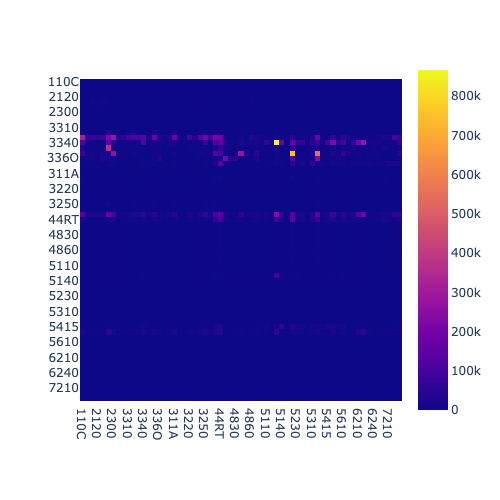

In [23]:
#px.imshow(final_equip_matrix, width=500, height=500)
Image("equipmat.png")

## Structures Investment Network

In [24]:
structure_df = expend_df[expend_df["asset"].map(lambda x: x[0] == "S")].copy()
structure_df["asset"] = structure_df["asset"].map(lambda x: "Mining" if x == "SM02" else "Other")
structure_df = structure_df.groupby(["industry", "asset"]).agg("sum")
structure_matrix = np.zeros((len(years), n_industries, n_industries))

for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):

            if industries[i] == "2130":
                structure_matrix[t,i,j] = structure_df.loc[(industries[j],"Mining"), years[t]]
            elif industries[i] == "2300":
                structure_matrix[t,i,j] = structure_df.loc[(industries[j],"Other"), years[t]]

final_structure_matrix = pd.DataFrame(structure_matrix.sum(axis = 0))
final_structure_matrix.columns = industries
final_structure_matrix.index = industries

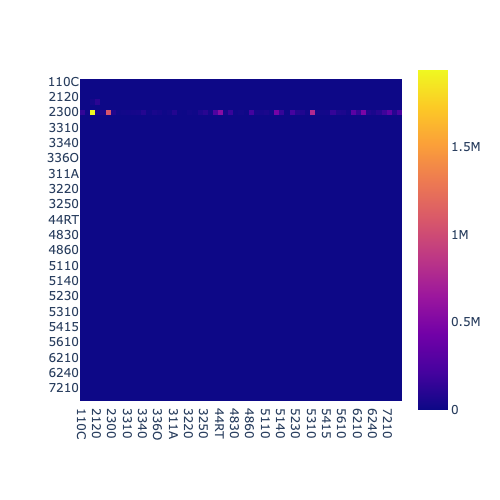

In [25]:
# px.imshow(final_structure_matrix, width=500, height=500)
Image("strucmat.png")

## Intellectual Property Investment Network

In [26]:

ipp_map = {
    "ENS1": "5110", 
    "ENS2": "5415", 
    "ENS3": "5415", 
    "RD11": "5412", 
    "RD12": "5412", 
    "RD23": "5412", 
    "RD21": "5412", 
    "RD22": "5412", 
    "RD24": "5412", 
    "RD25": "5412", 
    "RD31": "5412", 
    "RD32": "5412", 
    "RDOM": "5412", 
    "RD70": "5412", 
    "RD40": "5412", 
    "RD50": "5412", 
    "RD60": "5412", 
    "RD80": "5412", 
    "RD91": "5412", 
    "RD92": "5412", 
    "AE10": "5120", 
    "AE20": "5150", 
    "AE30": "5110", 
    "AE40": "5120", 
    "AE50": "711A"
}

In [27]:

ipp_df = expend_df[expend_df["asset"].map(lambda x: x in ipp_map.keys())].copy()
ipp_df["asset"] = ipp_df["asset"].map(lambda x: ipp_map[x])
ipp_df = ipp_df.groupby(["industry", "asset"]).agg("sum")
ipp_matrix = np.zeros((len(years), n_industries, n_industries))

for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):
            try:
                ipp_matrix[t,i,j] = ipp_df.loc[(industries[j],industries[i]), years[t]]
            except:
                continue
                
final_ipp_matrix = pd.DataFrame(ipp_matrix.sum(axis = 0))
final_ipp_matrix.columns = industries
final_ipp_matrix.index = industries

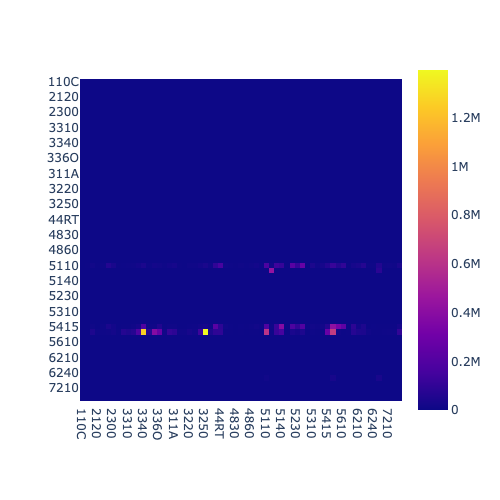

In [28]:
# px.imshow(final_ipp_matrix, width=500, height=500)
Image("ippmat.png")

## Final BEA Investment Network

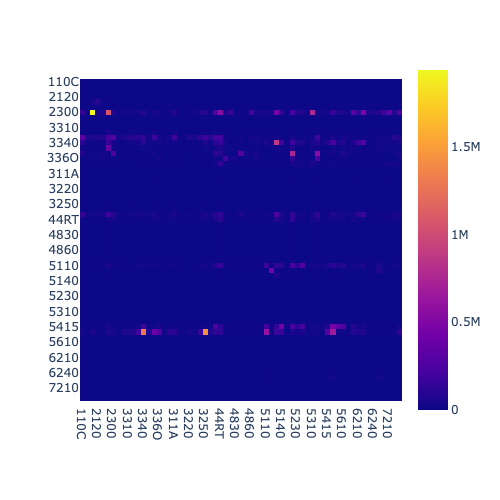

In [29]:
bea_matrix = final_equip_matrix + final_structure_matrix + final_ipp_matrix
# px.imshow(bea_matrix, width=500, height=500)
Image("finalbeamat.png")

##  Matrix Transformation to OECD

In [30]:
# with open("oecd_bea.json", "w") as f:
#     f.write(json.dumps(oecd_bea))

with open("oecd_bea.json", "r") as f:
    oecd_bea = json.loads(f.read())

In [31]:
rows = []
for i in oecd_bea.keys():
    for j in oecd_bea[i]:
        rows.append({
            "oecd_code": i,
            "bea_code": j
        })

pd.DataFrame(rows).to_csv("oecd_bea_crosswalk.csv", index=None)

In [32]:
tot_exp_df = expend_df[:-1].groupby("industry").agg("sum").sum(axis=1)

bea_total_exp = {}
for ind, val in tot_exp_df.items():
    bea_total_exp[ind] = val

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_9498/2979229283.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [33]:
ind = []
for key, val in oecd_bea.items():
    ind = ind + val

print(len(bea_total_exp))
print(len(ind))
bea_matrix.shape

industries = list(bea_matrix.columns)
sectors = list(oecd_bea.keys())

# row summing matrix
num_splits = {}
R = np.zeros((len(sectors), len(industries)))
for sec_i, sec in enumerate(sectors):
    for ind_i, ind in enumerate(industries):
        splits = np.sum([1 for k in oecd_bea.keys() if ind in oecd_bea[k]])
        R[sec_i,ind_i] = 1 / splits if ind in oecd_bea[sec] else 0

# column weighted averaging matrix
C = np.zeros((len(industries), len(sectors)))
for ind_i, ind in enumerate(industries):
    for sec_i, sec in enumerate(sectors):
        C[ind_i, sec_i] = bea_total_exp[ind] if ind in oecd_bea[sec] else 0

# C = normalize(C, axis=0, norm='l1')

print(R.shape)
print(np.array(bea_matrix).shape)
print(C.shape)

res = np.dot(np.dot(R, np.array(bea_matrix)), C)
res = normalize(res, axis = 0, norm='l1')

res = pd.DataFrame(res)
res.index = sectors
res.columns = sectors

res = res[np.sort(sectors)]
res.sort_index(inplace=True)

pd.set_option('display.max_columns', 100)

63
65
(44, 63)
(63, 63)
(63, 44)


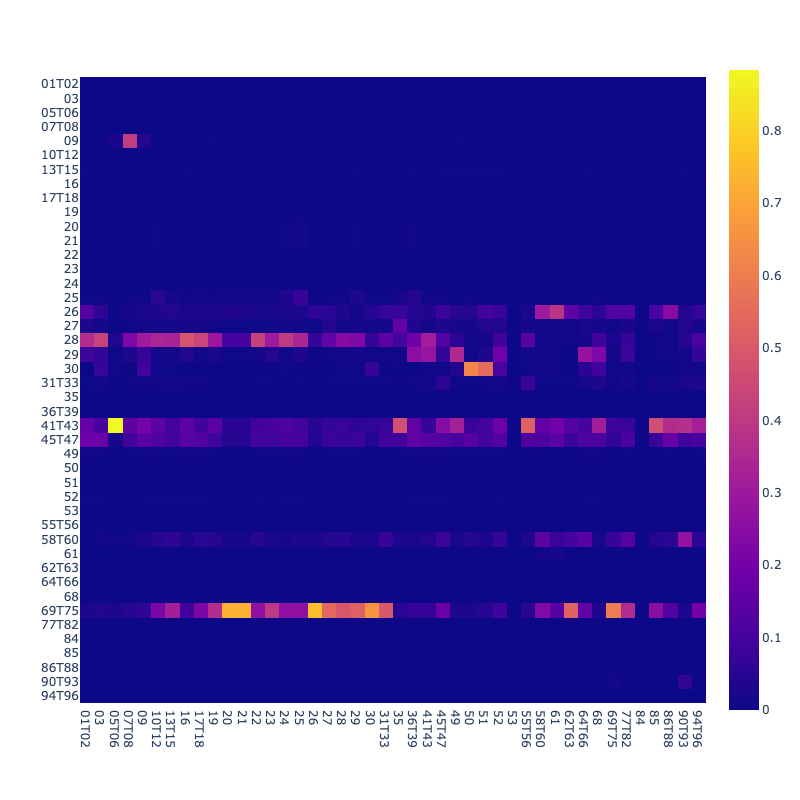

In [34]:
# px.imshow(res, width=800, height = 800)
Image("finaloecdmat.png")

## Comparison to VW-based Matrix

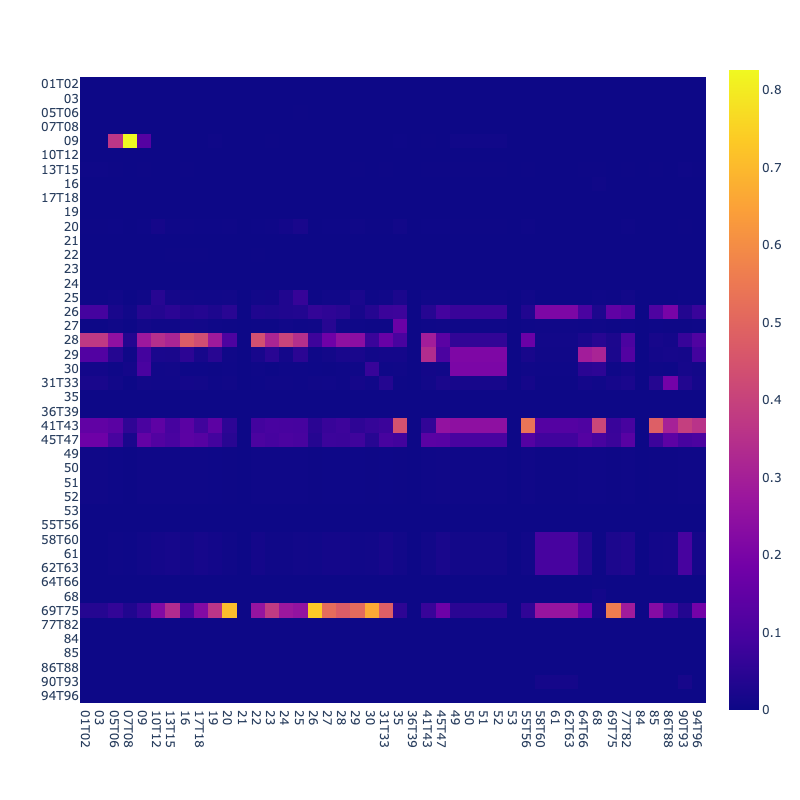

In [37]:
vw_matrix = pd.read_csv("investment_matrix.csv", index_col=0)
# px.imshow(vw_matrix, width=800, height = 800)
Image("VWoecdmat.png")

# BEA OECD Crosswalk Confidence

Here I score each BEA/OECD match by how many overlapping subsector matches they have.

In [21]:
with open("bea_naics.json", "r") as f:
    bea_naics = json.loads(f.read())

In [22]:
cw_df = pd.read_csv("oecd_bea_crosswalk.csv")
cw_df["isic"] = cw_df["oecd_code"].map(lambda x: x.split("T"))
cw_df["naics"] = cw_df["bea_code"].map(lambda x: [str(i) for i in bea_naics[x]] if not type(x) is float else np.nan)

In [23]:
naics_isic = pd.read_csv("raw_data/NAICS_ISIC.csv", dtype=str)
n_naics = len(naics_isic["NAICS2012Code"].unique())
n_isic = len(naics_isic["ISIC4Code"].unique())

def score_match(isic, naics, df):

    if np.nan in [isic, naics]: return 0

    naics_digits = len(naics[0])

    isic_mask = df["ISIC4Code"].map(lambda x: x[0:2] in isic)
    naics_mask = df["NAICS2012Code"].map(lambda x: type(x) is str and x[0:naics_digits] in naics)

    union = df[naics_mask | isic_mask]

    intersection = df[ naics_mask & isic_mask ]

    # print(isic)
    # print(naics)
    # display(df[ naics_mask & ~isic_mask ])

    # expected_match = n_isic / n_naics
    # print(n_isic)
    # print(n_naics)
    # print(expected_match)

    return (len(intersection) / len(union))

score_match(cw_df.loc[0,"isic"], cw_df.loc[0,"naics"], naics_isic)

0.7362637362637363

In [24]:
scores = []
for i, row in cw_df.iterrows():
    scores.append(score_match(row["isic"], row["naics"], naics_isic))
cw_df["scores"] = scores

In [25]:
pd.set_option('display.max_rows', None)
# cw_df.to_csv("oecd_bea_scored_cw.csv", index=False)
cw_df

,oecd_code,bea_code,isic,naics,scores
0,01T02,110C,"[01, 02]","[111, 112]",0.736264
1,03,113F,[03],"[113, 114, 115]",0.187500
2,05T06,2110,"[05, 06]",[211],0.571429
3,07T08,2120,"[07, 08]",[212],0.866667
4,09,2130,[09],[213],0.555556
5,10T12,311A,"[10, 12]","[311, 312]",0.855422
6,13T15,313T,"[13, 15]","[313, 314]",0.488372
7,13T15,315A,"[13, 15]","[315, 316]",0.120000
8,16,3210,[16],[321],0.687500
9,17T18,3220,"[17, 18]",[322],0.555556
